### 1. Define warp function. This function will be used for later pipeline function.

In [1]:
# import modules

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

In [2]:
# Defined by using test_images/straight_lines1.jpg
src = np.float32([[194,719],[595,449],[685,449],[1117,719]])
dst = np.float32([[320,719],[320,0],[960,0],[960,719]])

# Calculate warp matrix
Minv = cv2.getPerspectiveTransform(dst, src)
M = cv2.getPerspectiveTransform(src, dst)

def warp(img, inverse = False):
    
    img_size = (img.shape[1],img.shape[0])
    
    if (inverse):
        warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    else:
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

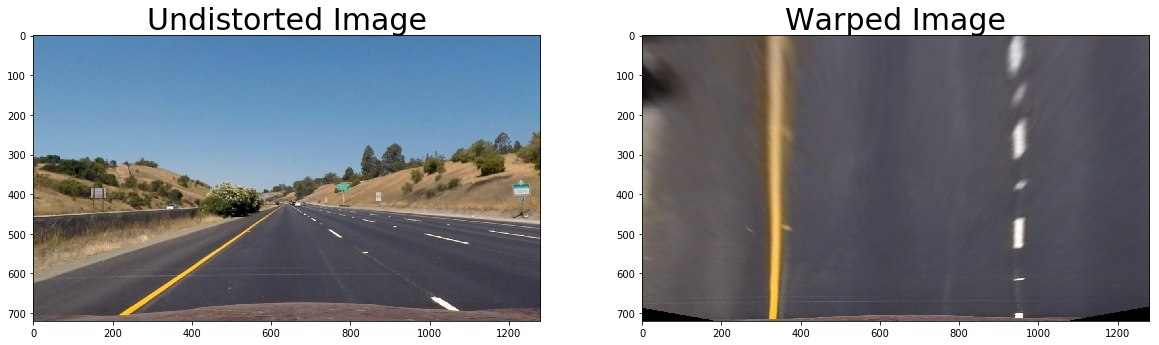

In [3]:
# Apply to test image
with open('camera_cal/wide_dist_pickle.p', mode='rb') as f:
    calibration_data = pickle.load(f)
    
mtx = calibration_data["mtx"]
dist = calibration_data["dist"]

image = mpimg.imread('test_images/straight_lines1.jpg')

image_undist = cv2.undistort(image, mtx, dist, None, mtx)
image_warped = warp(image_undist)
mpimg.imsave('test_images/straight_lines1_undist.jpg',image_undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image_undist)
ax1.set_title('Undistorted Image', fontsize=30)
#ax2.imshow(image_warped)
ax2.imshow(image_warped)
ax2.set_title('Warped Image', fontsize=30)
plt.show()

### 2. Define pipeline that computes thresholded, distorted and warped images.

In [4]:
def pipeline(img, s_thresh=(100, 255), sx_thresh=(15, 255)):
    img = np.copy(img)
        
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=3) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Computes combined thresholded image
    thresholded = np.zeros_like(s_channel)
    thresholded[((sxbinary == 1) | (s_binary == 1)) & (l_channel > 40)] = 1
    
    # Undistort and warp the image
    binary_undist = cv2.undistort(thresholded, mtx, dist, None, mtx)
    binary_warped = warp(binary_undist)

    # Re-convert to binary image
    ret = np.zeros(binary_warped.shape, dtype=np.uint8)
    ret[binary_warped>0.5] = 1
    
    return ret, binary_undist

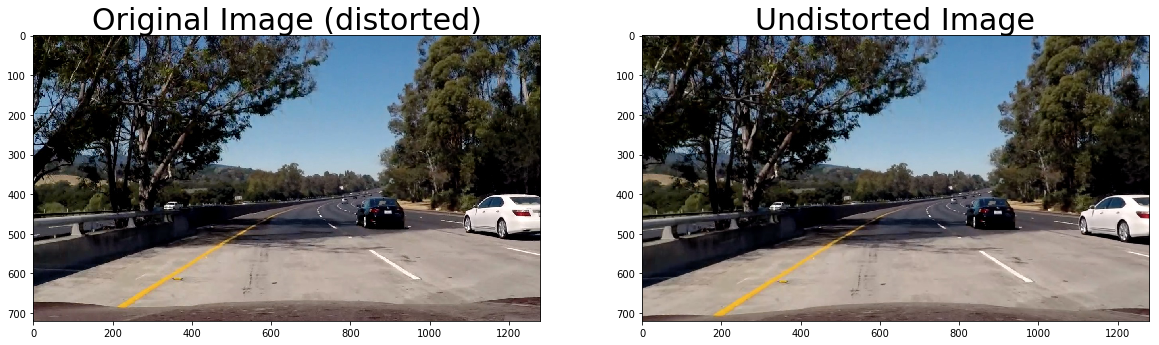

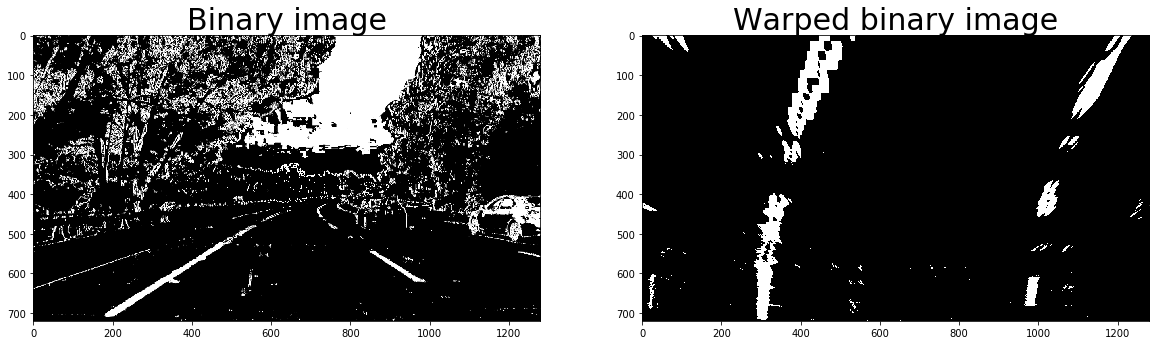

In [5]:
# Apply to test image

image = mpimg.imread('test_images/test5.jpg')
image_undist = cv2.undistort(image, mtx, dist, None, mtx)
ret, binary_undist = pipeline(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image (distorted)', fontsize=30)
ax2.imshow(image_undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(binary_undist, cmap='gray')
ax1.set_title('Binary image', fontsize=30)
ax2.imshow(ret, cmap='gray')
ax2.set_title('Warped binary image', fontsize=30)
plt.show()

mpimg.imsave("output_images/undistorted.jpg", image_undist)
mpimg.imsave("output_images/binary_combo.jpg", binary_undist, cmap='gray')
mpimg.imsave("output_images/warped_binary.jpg", ret, cmap='gray')

### Create polinominal using histogram and window search.

### Implement sliding window search

In [6]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None
        
        self.ploty = None

In [7]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
def sliding_window_search(binary_warped, Left_lane, Right_lane):
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the width of the windows +/- margin
    margin = 100

    if((Left_lane.detected == True) & (Right_lane.detected == True)):
        skip_sliding_window = True
    else:
        skip_sliding_window = False
    
    if skip_sliding_window:
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!       
        left_fit = Left_lane.current_fit
        right_fit = Right_lane.current_fit

        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    else:        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        if (Left_lane != None) & (Right_lane != None):
            Left_lane.detected = True
            Right_lane.detected = True

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    Left_lane.allx = leftx
    Left_lane.ally = lefty
    Right_lane.allx = rightx
    Right_lane.ally = righty

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    Left_lane.current_fit = left_fit
    Right_lane.current_fit = right_fit
    
    # Color left and right lane
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate x and y values for plotting
    if(Left_lane.ploty == None):
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        Left_lane.ploty = ploty
        Right_lane.ploty = ploty
    
    ploty = Left_lane.ploty
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Average
    # Insert to the recent fitted list
    Left_lane.recent_xfitted.insert(0,left_fitx)
    Right_lane.recent_xfitted.insert(0,right_fitx)
    # Remove if exceeds maximum length
    while(len(Left_lane.recent_xfitted)>5):
        Left_lane.recent_xfitted.pop()
        Right_lane.recent_xfitted.pop()

    #average x values of the fitted line over the last n iterations
    Left_lane.bestx = np.mean(Left_lane.recent_xfitted, axis=0)
    Right_lane.bestx = np.mean(Right_lane.recent_xfitted, axis=0)

    #polynomial coefficients averaged over the last n iterations
    Left_lane.best_fit = np.polyfit(ploty, Left_lane.bestx, 2)
    Right_lane.best_fit = np.polyfit(ploty, Right_lane.bestx, 2)
    
    return out_img

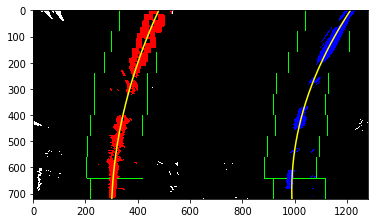

In [8]:
binary_warped, dummy = pipeline(image)

Left_lane = Line()
Right_lane = Line()

out_img = sliding_window_search(binary_warped, Left_lane, Right_lane)

plt.imshow(out_img)
plt.plot(Left_lane.bestx, Left_lane.ploty, color='yellow')
plt.plot(Right_lane.bestx, Right_lane.ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.savefig("output_images/color_fit_line.png")
plt.show()

In [9]:
def calculate_curvature(Left_lane, Right_lane):
    y_eval = 719
    
    left_fit = Left_lane.best_fit
    right_fit = Right_lane.best_fit
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/100 # meters per pixel in y dimension
    xm_per_pix = 3.7/670 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(Left_lane.ploty*ym_per_pix, Left_lane.bestx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(Right_lane.ploty*ym_per_pix, Right_lane.bestx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    Left_lane.radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    Right_lane.radius_of_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    #curverad = 1/(0.5*(1/left_curverad+1/right_curverad))
    #print(curverad, "m")    
    return

In [10]:
calculate_curvature(Left_lane, Right_lane)

print(Left_lane.radius_of_curvature, 'm', Right_lane.radius_of_curvature, 'm')

282.196842454 m 171.672970455 m


### Draw result on (undistorted) image.

In [11]:
def draw_lane(image_undist, Left_lane, Right_lane):
    # Overlay lane information on (undistorted) image.
    # Create an image to draw the lines on
    #warp_zero = np.zeros_like(image_undist).astype(np.uint8)
    color_warp = np.zeros_like(image_undist).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([Left_lane.bestx, Left_lane.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([Right_lane.bestx, Right_lane.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Draw lane line using out_img.
    color_warp[Left_lane.ally,Left_lane.allx] = [255,0,0]
    color_warp[Right_lane.ally,Right_lane.allx] = [0,0,255]
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, inverse = True)
    # Combine the result with the original image
    result = cv2.addWeighted(image_undist, 0.7, newwarp, 0.3, 0.0)
    
    return result

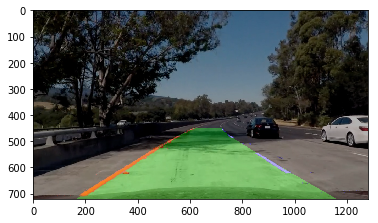

In [12]:
#plt.imshow(draw_lane(binary_warped, image_undist, left_fitx, right_fitx, ploty))
result = draw_lane(image_undist, Left_lane, Right_lane)
plt.imshow(result)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

mpimg.imsave("output_images/example_output.jpg", result)

In [13]:
def draw_text(img, Left_lane, Right_lane):
    left_curverad = float(Left_lane.radius_of_curvature)
    right_curverad = float(Right_lane.radius_of_curvature)
    curverad = 1/(0.5*(1/left_curverad+1/right_curverad))
    fontscale = 1.0
    color=(255, 255, 255)
    fontface = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,"Radius of curvature = " + str(int(curverad)) + "m",(50,50),fontface,fontscale,color)
    
    offset_px = (Right_lane.bestx[-1] + Left_lane.bestx[-1])/2 - 640
    direction = "left" if offset_px < 0 else "right"
    offset_m_abs = np.abs(offset_px)*3.7/670
    cv2.putText(img,"Vehicle is " + '%.2f' % offset_m_abs + "m " + direction + " of center",(50,100),fontface,fontscale,color)

    return img

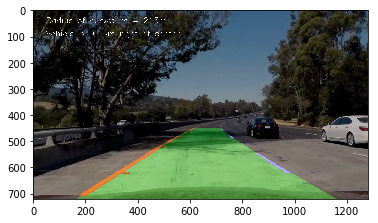

In [14]:
result = draw_text(result, Left_lane, Right_lane)
plt.imshow(result)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### Process video frames

In [ ]:
def process_image(image):
    # Pipeline function that generate output image from distorted original image.
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # Undisorted image
    image_undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Generate binary image, where lane lines are extracted
    binary_warped, dummy = pipeline(image)
    
    # Fit polynominal to left and right lane line
    out_img = sliding_window_search(binary_warped, Left_lane, Right_lane)
    
    # Calculate curvature
    calculate_curvature(Left_lane, Right_lane)
    
    # Overlay lane information on (undistorted) image.
    result = draw_lane(image_undist, Left_lane, Right_lane)
    
    result = draw_text(result, Left_lane, Right_lane)
    return result

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Left_lane = Line()
Right_lane = Line()

project_output = 'project_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [ ]:
print(Left_lane.detected)